In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-09 23:41:57.557781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Directories containing normal and abnormal audio files
normal_folder = "/Users/Downloads/archive/normal"
abnormal_folder = "/Users/Downloads/archive/abnormal"

In [4]:
def load_audios(path, label):
    audio_data = []
    data_labels = []
    sample_rates = []

    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_data.append(audio)
            data_labels.append(label)
            sample_rates.append(sample_rate)

    return audio_data, data_labels, sample_rates


# Load the datasets
abnormal_audio, abnormal_labels, _ = load_audios(abnormal_folder, label=1)
normal_audio, normal_labels, sample_rate = load_audios(normal_folder, label=0)

In [5]:
# Extract MFCC features from audio files
def extract_mfccs_features(audio_data, sample_rate, n_mfcc=13):
    mfcc_features = librosa.feature.mfcc(
        y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    processed_mfccs = np.mean(mfcc_features.T, axis=0)
    return processed_mfccs

In [6]:
#get spectral features
def extract_spectral_features(audio_data, sample_rate):
    centroids = librosa.feature.spectral_centroid(
        y=audio_data, sr=sample_rate)[0]
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)[0]
    contrast = librosa.feature.spectral_contrast(
        y=audio_data, sr=sample_rate)[0]
    return np.mean(centroids), np.mean(rolloff), np.mean(contrast)

In [7]:
#Get the temporal features
def extract_temporal_features(audio_data):
    zero_crossing_rates = librosa.feature.zero_crossing_rate(audio_data)[0]
    auto_correlation = librosa.autocorrelate(audio_data)
    return np.mean(zero_crossing_rates), np.mean(auto_correlation)

In [8]:
#Augument the data 
def augment_audio_data(audio_data, sample_rate, noise_factor=0.005, shift_max=0.2):
    # Time Shifting
    time_shift = np.random.randint(int(sample_rate * shift_max))
    augmented_audio_data = np.roll(audio_data, time_shift)

    # Adding Noise
    noise = np.random.randn(len(augmented_audio_data))
    augmented_audio_data = augmented_audio_data + noise_factor * noise

    return augmented_audio_data

In [9]:
#Applying features 
def extract_audio_features(audio_data_list, sample_rate):
    audio_features = []
    for audio_data in audio_data_list:
        mfccs = extract_mfccs_features(audio_data, sample_rate)
        spectral_features = extract_spectral_features(audio_data, sample_rate)
        temporal_features = extract_temporal_features(audio_data)
        all_features = np.concatenate(
            [mfccs, spectral_features, temporal_features])
        audio_features.append(all_features)
    return np.array(audio_features)


# Extract features for both normal and abnormal data
normal_features_data = extract_audio_features(normal_audio, sample_rate[0])
abnormal_features_data = extract_audio_features(abnormal_audio, sample_rate[0])

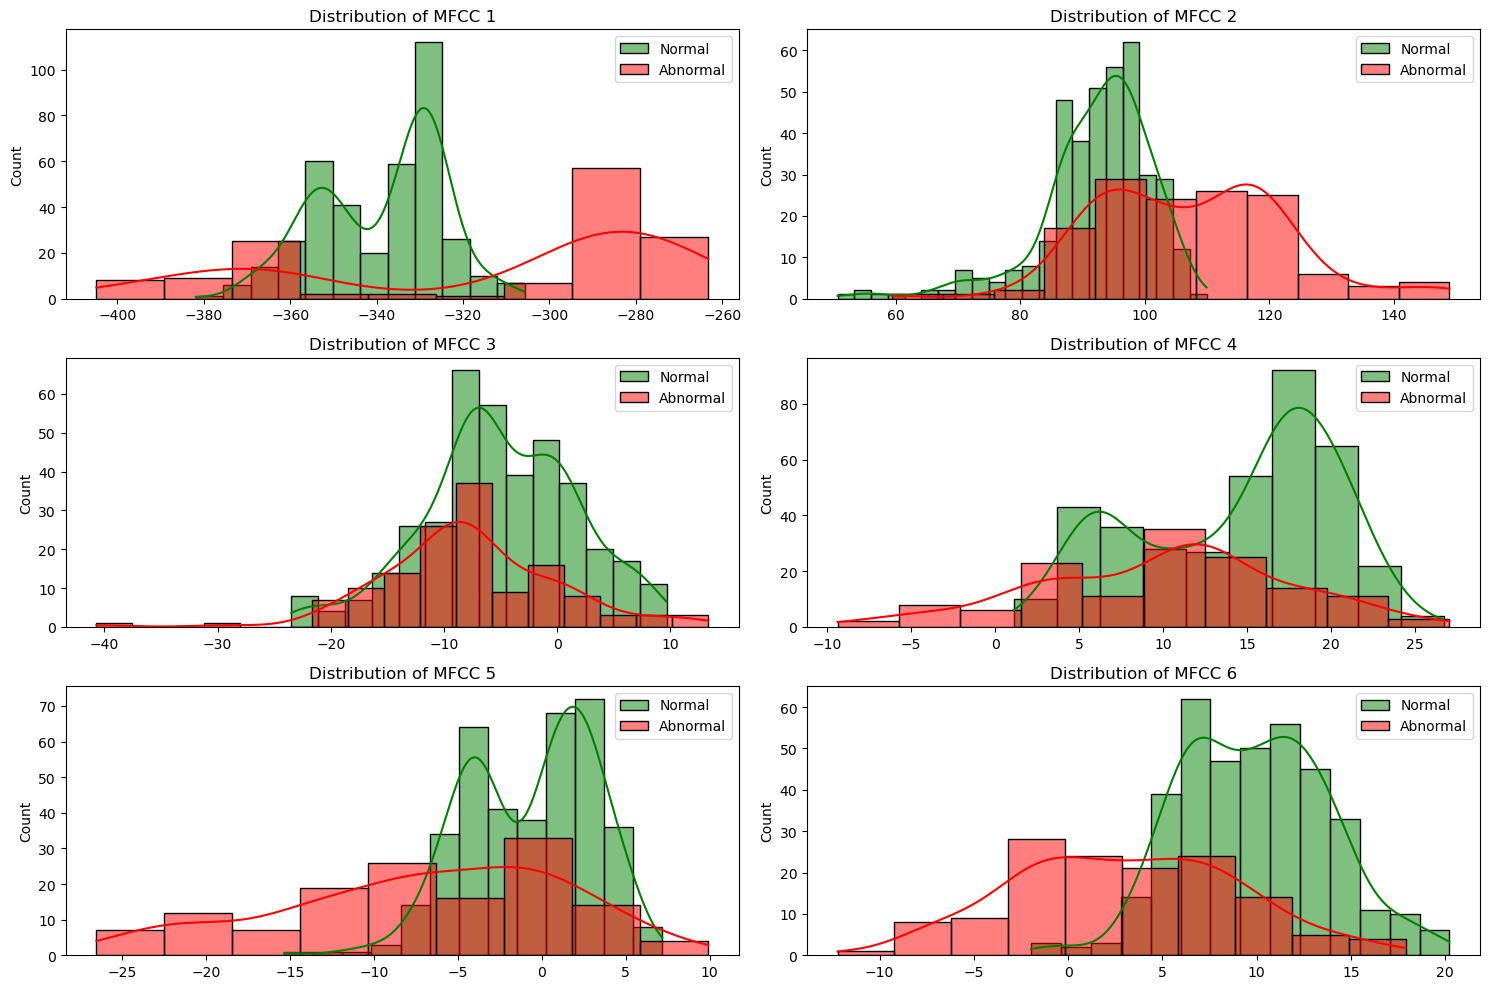

In [10]:
# Plot distribution of first 6 MFCC separatelyfeatures
plt.figure(figsize=(15, 10))

for i in range(6):
    plt.subplot(3, 2, i+1)  # Creating subplots in a 3x2 grid
    sns.histplot(normal_features_data[:, i],
                 color='green', label='Normal', kde=True)
    sns.histplot(abnormal_features_data[:, i],
                 color='red', label='Abnormal', kde=True)
    plt.title(f'Distribution of MFCC {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

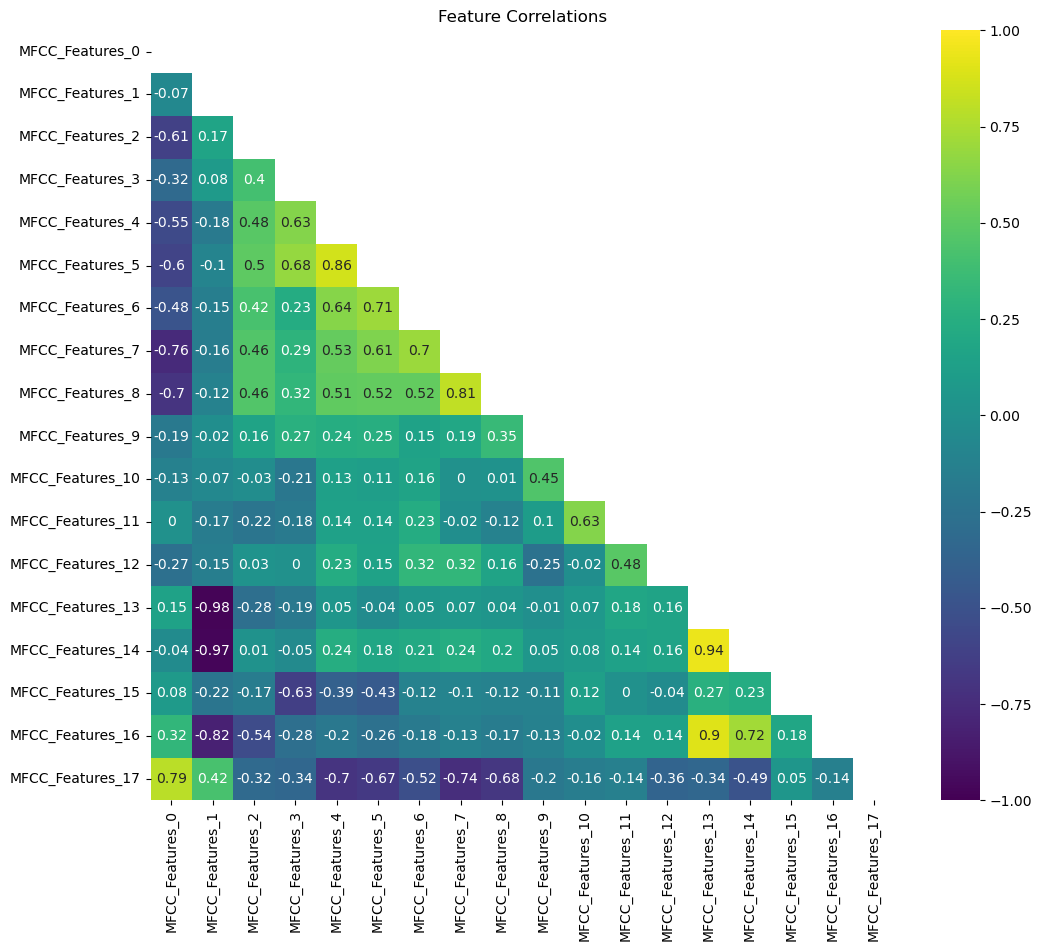

In [11]:
# Combine normal and abnormal features for correlation analysis
import pandas as pd
combined_data = np.vstack((normal_features_data, abnormal_features_data))
data_labels = ['MFCC_Features_' + str(i) for i in range(combined_data.shape[1])]

# Create a DataFrame for easier plotting
data_df = pd.DataFrame(combined_data, columns=data_labels)

# Plotting the heatmap
mask = np.triu(np.ones_like(data_df.corr(), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(round(data_df.corr(), 2), annot=True,
            mask=mask, vmin=-1, vmax=1, cmap='viridis')
plt.title('Feature Correlations')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


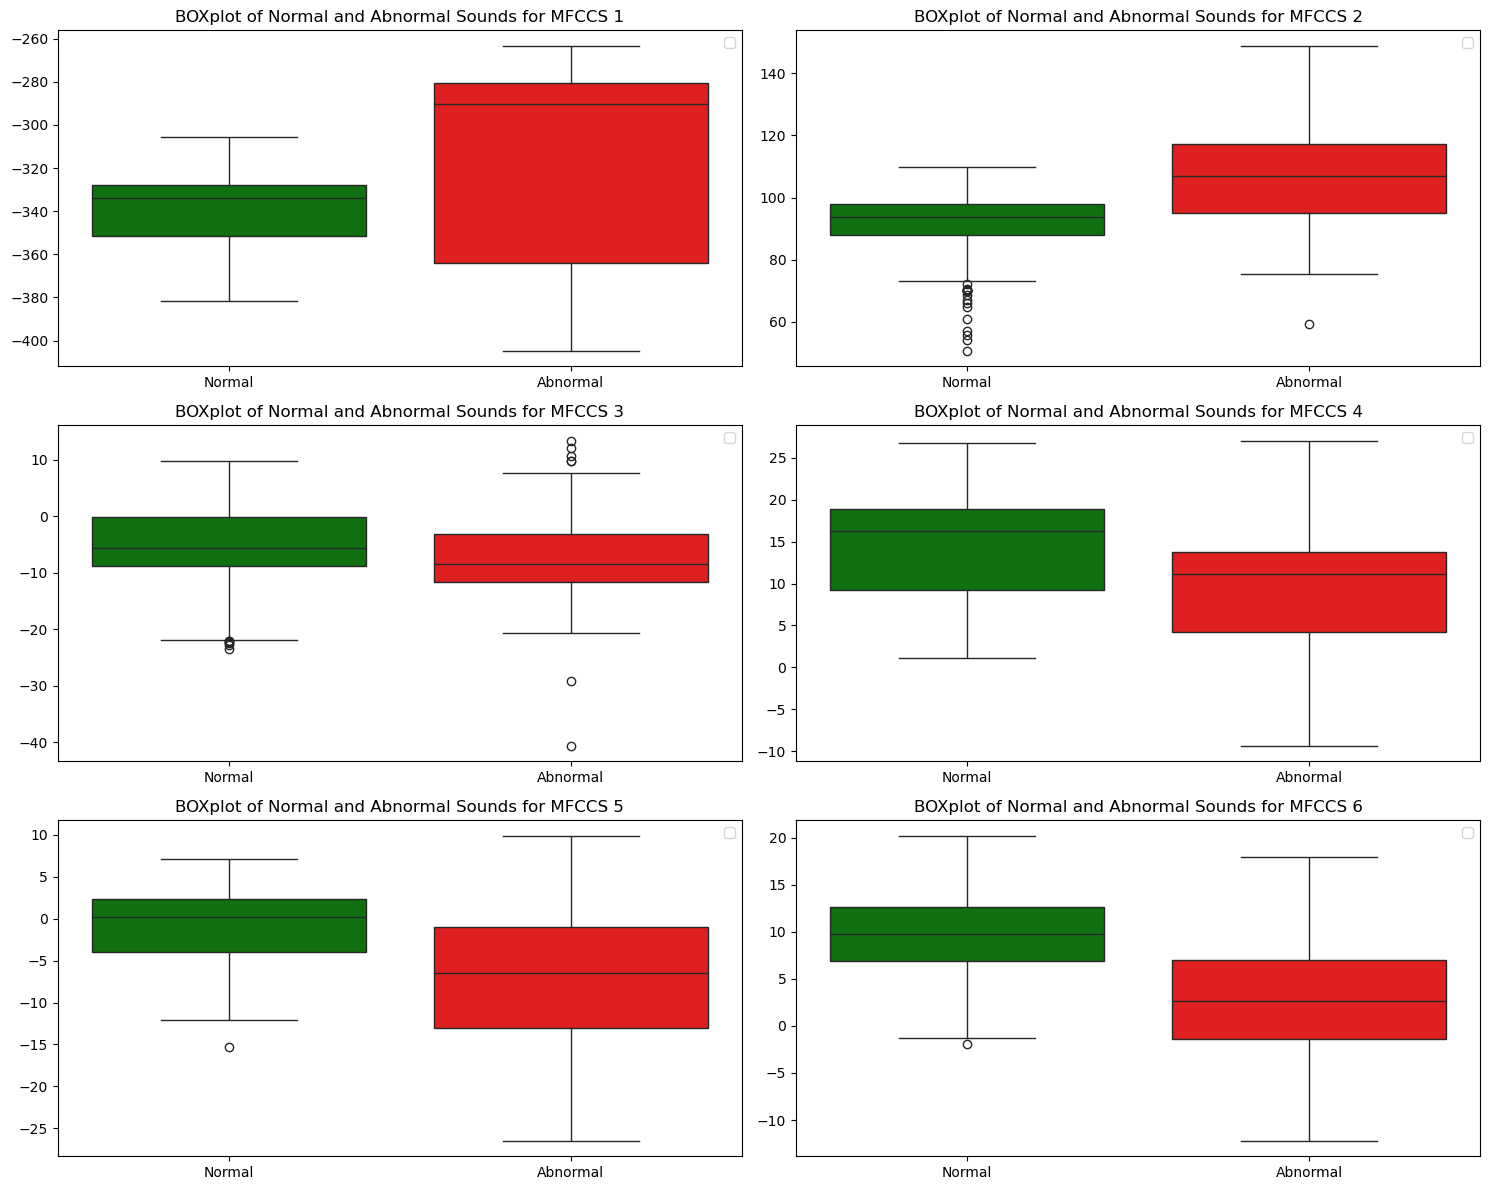

In [12]:
#Boax Plot of first 6 features
plt.figure(figsize=(15, 12))

for i in range(6):
    plt.subplot(3, 2, i+1)  # Creating subplots in a 3x2 grid
    sns.boxplot(data=[normal_features_data[:, i], abnormal_features_data[:, i]],palette=['green','red'])
    plt.xticks([0, 1], ['Normal', 'Abnormal'])
    plt.title(f'BOXplot of Normal and Abnormal Sounds for MFCCS {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

In [13]:
#Model Building

In [14]:
X_data = np.concatenate((normal_features_data, abnormal_features_data))
y_labels = np.concatenate(
    (np.zeros(len(normal_features_data)), np.ones(len(abnormal_features_data))))
# Define the input shape based on the numbers in the feature array
input_shape_data = X_data.shape[1:]
print(X_data.shape[1:])

(18,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Split the data into training and test sets
X_train_data, X_test_data, y_train_labels, y_test_labels = train_test_split(
    X_data, y_labels, test_size=0.2, random_state=42, stratify=y_labels, shuffle=True)

# Initialize the scaler
data_scaler = StandardScaler()

# STandardizing the data
X_train_scaled_data = data_scaler.fit_transform(X_train_data)
X_test_scaled_data = data_scaler.transform(X_test_data)

In [16]:
print(f'Training feature size:{X_train_scaled_data.shape}')
print(f'Testing feature size:{X_test_scaled_data.shape}')

Training feature size:(415, 18)
Testing feature size:(104, 18)


In [17]:
def build_custom_model(input_shape_data):
    custom_model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape_data),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    custom_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
    return custom_model


# Initialize the custom model
custom_model = build_custom_model(input_shape_data)

In [18]:
# Train the model with validation data
history = custom_model.fit(X_train_scaled_data, y_train_labels,
                           epochs=500, batch_size=32, validation_split=0.5, verbose=0)

4/4 [==============================] - 0s 1ms/step
Accuracy: 0.9711538461538461
Precision: 0.9629629629629629
Recall: 0.9285714285714286
F1 Score: 0.9454545454545454
AUC-ROC: 0.9577067669172933


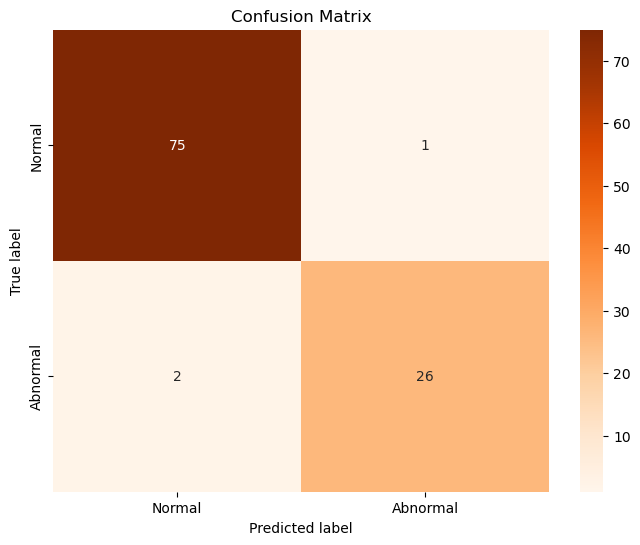

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# Predict classes on the test set
y_predicted = custom_model.predict(X_test_scaled_data)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate performance metrics
accuracy_custom = accuracy_score(y_test_labels, y_predicted)
precision_custom = precision_score(y_test_labels, y_predicted)
recall_custom = recall_score(y_test_labels, y_predicted)
f1_custom = f1_score(y_test_labels, y_predicted)
roc_auc_custom = roc_auc_score(y_test_labels, y_predicted)

# Print metrics
print(f"Accuracy: {accuracy_custom}")
print(f"Precision: {precision_custom}")
print(f"Recall: {recall_custom}")
print(f"F1 Score: {f1_custom}")
print(f"AUC-ROC: {roc_auc_custom}")

# Plot confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=[
            'Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
#CNN Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import InputLayer
# Assuming X_train_scaled, X_test_scaled have shape (num_samples, num_features)

# Reshape input data to match the expected input shape of the model
# Add a dimension for the number of channels (1 in this case)
X_train_reshaped = X_train_scaled_data.reshape(-1, X_train_scaled_data.shape[1], 1)
X_test_reshaped = X_test_scaled_data.reshape(-1, X_test_scaled_data.shape[1], 1)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Define the model architecture


def create_model(input_shape):
    model = tf.keras.Sequential([
        InputLayer(input_shape=input_shape),  # Specify the input shape here
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


cnn_model = create_model(X_train_reshaped.shape[1:])

# Fit the model
history = cnn_model.fit(
    X_train_reshaped, y_train_labels,
    validation_data=(X_test_reshaped, y_test_labels),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/500
13/13 [==============================] - 1s 27ms/step - loss: 0.5513 - accuracy: 0.7735 - val_loss: 0.3045 - val_accuracy: 0.9519
Epoch 2/500
13/13 [==============================] - 0s 14ms/step - loss: 0.2852 - accuracy: 0.9133 - val_loss: 0.2329 - val_accuracy: 0.9327
Epoch 3/500
13/13 [==============================] - 0s 15ms/step - loss: 0.2142 - accuracy: 0.9398 - val_loss: 0.1841 - val_accuracy: 0.9615
Epoch 4/500
13/13 [==============================] - 0s 22ms/step - loss: 0.2339 - accuracy: 0.9301 - val_loss: 0.1372 - val_accuracy: 0.9808
Epoch 5/500
13/13 [==============================] - 0s 15ms/step - loss: 0.1364 - accuracy: 0.9566 - val_loss: 0.1498 - val_accuracy: 0.9615
Epoch 6/500
13/13 [==============================] - 0s 14ms/step - loss: 0.1054 - accuracy: 0.9518 - val_loss: 0.1670 - val_accuracy: 0.9615
Epoch 7/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0897 - accuracy: 0.9735 - val_loss: 0.2103 - val_accuracy: 0.9519
Epoch 

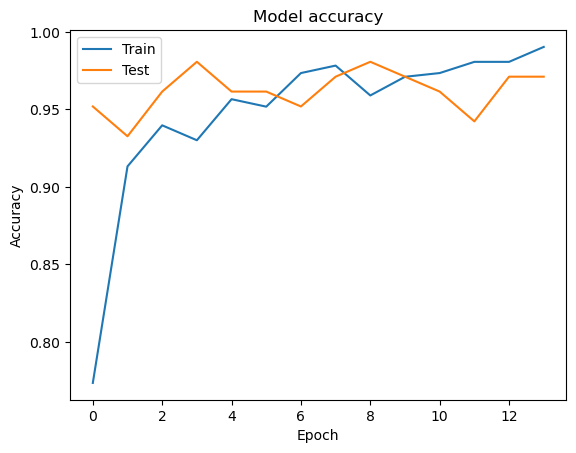

4/4 [==============================] - 0s 3ms/step


0.9807692

In [28]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model
y_pred_prob = cnn_model.predict(X_test_scaled_data)
y_pred = [1 if prob >= 0.6 else 0 for prob in y_pred_prob]

accuracy = tf.keras.metrics.Accuracy()
accuracy(y_test_labels, y_pred).numpy()

4/4 [==============================] - 0s 3ms/step
Accuracy: 0.9807692307692307
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.962962962962963
AUC-ROC: 0.9642857142857143


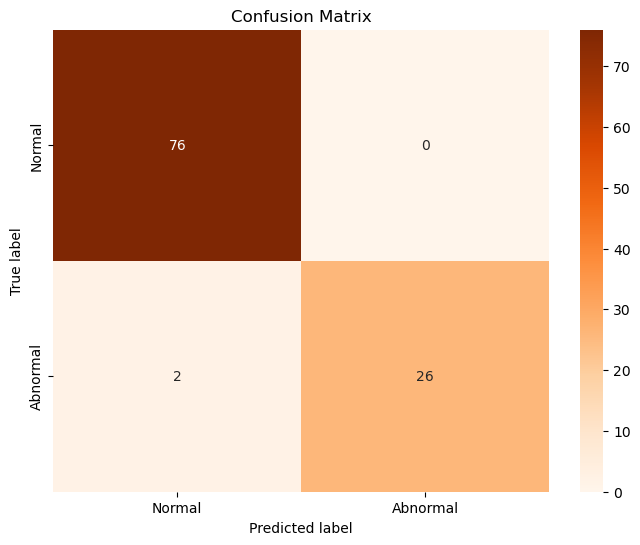

In [29]:
# Predict classes on the test set
y_predicted = cnn_model.predict(X_test_scaled_data)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate performance metrics
accuracy_custom = accuracy_score(y_test_labels, y_predicted)
precision_custom = precision_score(y_test_labels, y_predicted)
recall_custom = recall_score(y_test_labels, y_predicted)
f1_custom = f1_score(y_test_labels, y_predicted)
roc_auc_custom = roc_auc_score(y_test_labels, y_predicted)

# Print metrics
print(f"Accuracy: {accuracy_custom}")
print(f"Precision: {precision_custom}")
print(f"Recall: {recall_custom}")
print(f"F1 Score: {f1_custom}")
print(f"AUC-ROC: {roc_auc_custom}")

# Plot confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=[
            'Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


def build_lstm_model(input_shape_data):
    lstm_model = Sequential([
        LSTM(64, input_shape=input_shape_data, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    return lstm_model


# Initialize the LSTM model
lstm_model = build_lstm_model(X_train_reshaped.shape[1:])

# Train the LSTM model with validation data
lstm_history = lstm_model.fit(X_train_scaled_data, y_train_labels,
                              epochs=100, batch_size=32, validation_split=0.2, verbose=0)


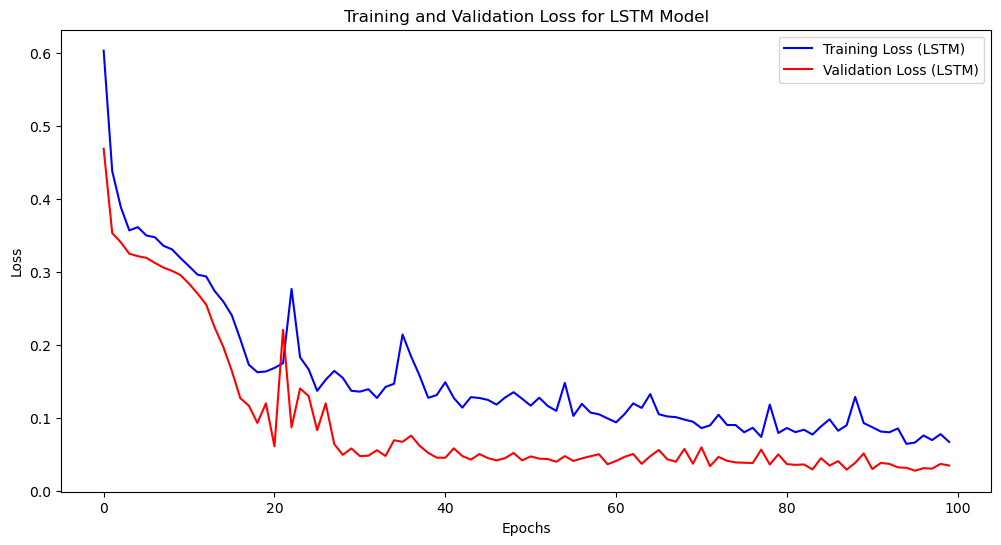

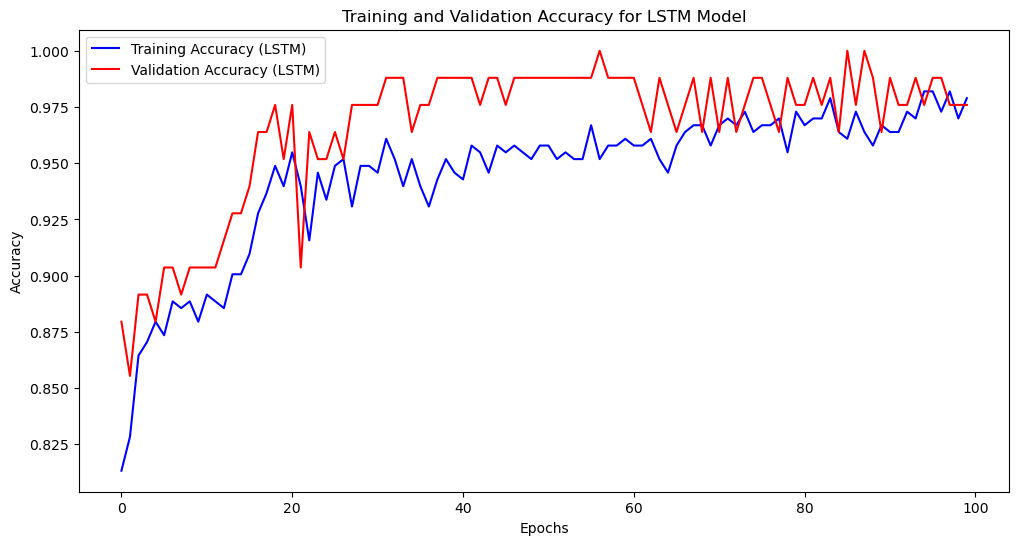

In [25]:
# Extracting training history
train_loss_lstm = lstm_history.history['loss']
val_loss_lstm = lstm_history.history['val_loss']
train_accuracy_lstm = lstm_history.history['accuracy']
val_accuracy_lstm = lstm_history.history['val_accuracy']

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(train_loss_lstm, label='Training Loss (LSTM)', color='blue')
plt.plot(val_loss_lstm, label='Validation Loss (LSTM)', color='red')
plt.title('Training and Validation Loss for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_lstm, label='Training Accuracy (LSTM)', color='blue')
plt.plot(val_accuracy_lstm, label='Validation Accuracy (LSTM)', color='red')
plt.title('Training and Validation Accuracy for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 [==============================] - 1s 5ms/step
Accuracy: 0.9519230769230769
Precision: 0.896551724137931
Recall: 0.9285714285714286
F1 Score: 0.912280701754386
AUC-ROC: 0.9445488721804511


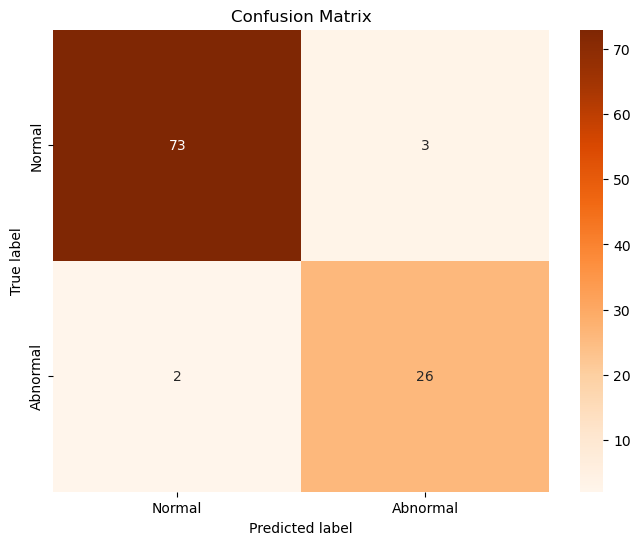

In [26]:
# Predict classes on the test set
y_predicted = lstm_model.predict(X_test_scaled_data)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate performance metrics
accuracy_custom = accuracy_score(y_test_labels, y_predicted)
precision_custom = precision_score(y_test_labels, y_predicted)
recall_custom = recall_score(y_test_labels, y_predicted)
f1_custom = f1_score(y_test_labels, y_predicted)
roc_auc_custom = roc_auc_score(y_test_labels, y_predicted)

# Print metrics
print(f"Accuracy: {accuracy_custom}")
print(f"Precision: {precision_custom}")
print(f"Recall: {recall_custom}")
print(f"F1 Score: {f1_custom}")
print(f"AUC-ROC: {roc_auc_custom}")

# Plot confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=[
            'Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()